In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

In [3]:
DIR_TELEGRAF = '../data/telegraf'

In [4]:
def plot_cpu(workload, time, num_drivers=1):
    time = int(time)

    df = pd.read_csv(f"{DIR_TELEGRAF}/{workload}/{time}/cpu.csv", comment='#')
    df = df[['host', '_time', '_field', '_value']]
    df['_time'] = list(map(lambda x: x.tz_localize(None), pd.to_datetime(df['_time'])))

    hosts = df['host'].unique()
    # print(hosts)

    df_usage = df[df['_field'] == 'usage_idle'].copy()
    df_usage['_value'] = 100 - df_usage['_value']
    df_usage = df_usage[['host', '_time', '_value']]
    df_usage.rename(columns={'_time': 'time', '_value': 'value'}, inplace=True)

    x = datetime.datetime.fromtimestamp(time, tz=datetime.timezone.utc).replace(tzinfo=None)

    df_usage['time_rel'] = (df_usage['time'] - x).dt.total_seconds()

    driver_hosts = [f'cloud{i}lennart' for i in range(num_drivers)]
    executor_hosts = list(filter(lambda host: host not in driver_hosts, hosts))

    driver_usage = df_usage[df_usage['host'].isin(driver_hosts)].groupby(['time_rel', 'time'], as_index=False).agg({'value': 'mean'})
    driver_usage['host'] = '_driver-average'
    executor_usage = df_usage[df_usage['host'].isin(executor_hosts)].groupby(['time_rel', 'time'], as_index=False).agg({'value': 'mean'})
    executor_usage['host'] = '_executor-average'
    df_usage = pd.concat([df_usage, driver_usage, executor_usage]).sort_values(['time_rel', 'host'])
    
    hosts = df_usage['host'].unique()

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(int(math.ceil(len(hosts) / 2)), ncols=2, figsize=(10, 2 * len(hosts)))
    axs = axs.flatten()
    # Plotting
    for i, host in enumerate(hosts):

        df_host = df_usage[df_usage['host'] == host].copy()
        df_host['time'] = pd.to_datetime(df_host['time'])
        df_host.set_index('time', inplace=True)
        rolling_avg = df_host['value'].rolling(window='60s', min_periods=1).mean()

        axs[i].plot(df_host['time_rel'], df_usage[df_usage['host'] == host]['value'], label=host)
        axs[i].plot(df_host['time_rel'], rolling_avg, label=host)

        axs[i].set_title('Usage for ' + host)
        axs[i].set_xlabel('Time Relative to Start')
        axs[i].set_ylabel('Usage')
        axs[i].set_xlim([df_usage['time_rel'].min(), df_usage['time_rel'].max()])  # Set x limits
        axs[i].set_ylim([0, 100])  # Set y limits

    # Adjust the layout
    fig.tight_layout()

    # Show the plot
    plt.show()

In [5]:
def plot_mem(workload, time, num_drivers=0):

    time = int(time)

    df = pd.read_csv(f'{DIR_TELEGRAF}/{workload}/{time}/mem.csv', comment='#')
    df = df[['host', '_time', '_field', '_value']]
    df['_time'] = list(map(lambda x: x.tz_localize(None), pd.to_datetime(df['_time'])))
    df.rename(columns={'_time': 'time', '_field': 'field', '_value': 'value'}, inplace=True)

    hosts = df['host'].unique()
    fields = df['field'].unique()

    df_grouped = df.pivot_table(index=['time', 'host'], columns='field', values='value').reset_index()

    x = datetime.datetime.fromtimestamp(time, tz=datetime.timezone.utc).replace(tzinfo=None)

    df_grouped['time_rel'] = (df_grouped['time'] - x).dt.total_seconds()

    for field in fields:
        df_grouped[f'{field}_rel'] = df_grouped[field] / df_grouped['total']
    # df_grouped['used_rel'] = df_grouped['used'] / df_grouped['total']
    display(df_grouped)
    
    fig, axs = plt.subplots(len(hosts), figsize=(6, 4 * len(hosts)))

    for i, host in enumerate(hosts):

        df_host = df_grouped[df_grouped['host'] == host]

        axs[i].plot(df_host['time_rel'], df_host['used_rel'], label=host)
        
        axs[i].set_title('Usage for ' + host)
        axs[i].set_xlabel('Time Relative to Start')
        axs[i].set_ylabel('Usage')
        axs[i].set_xlim([df_grouped['time_rel'].min(), df_grouped['time_rel'].max()])  # Set x limits
        axs[i].set_ylim([0, 100])  # Set y limits

    # Adjust the layout
    fig.tight_layout()

    # Show the plot
    plt.show()

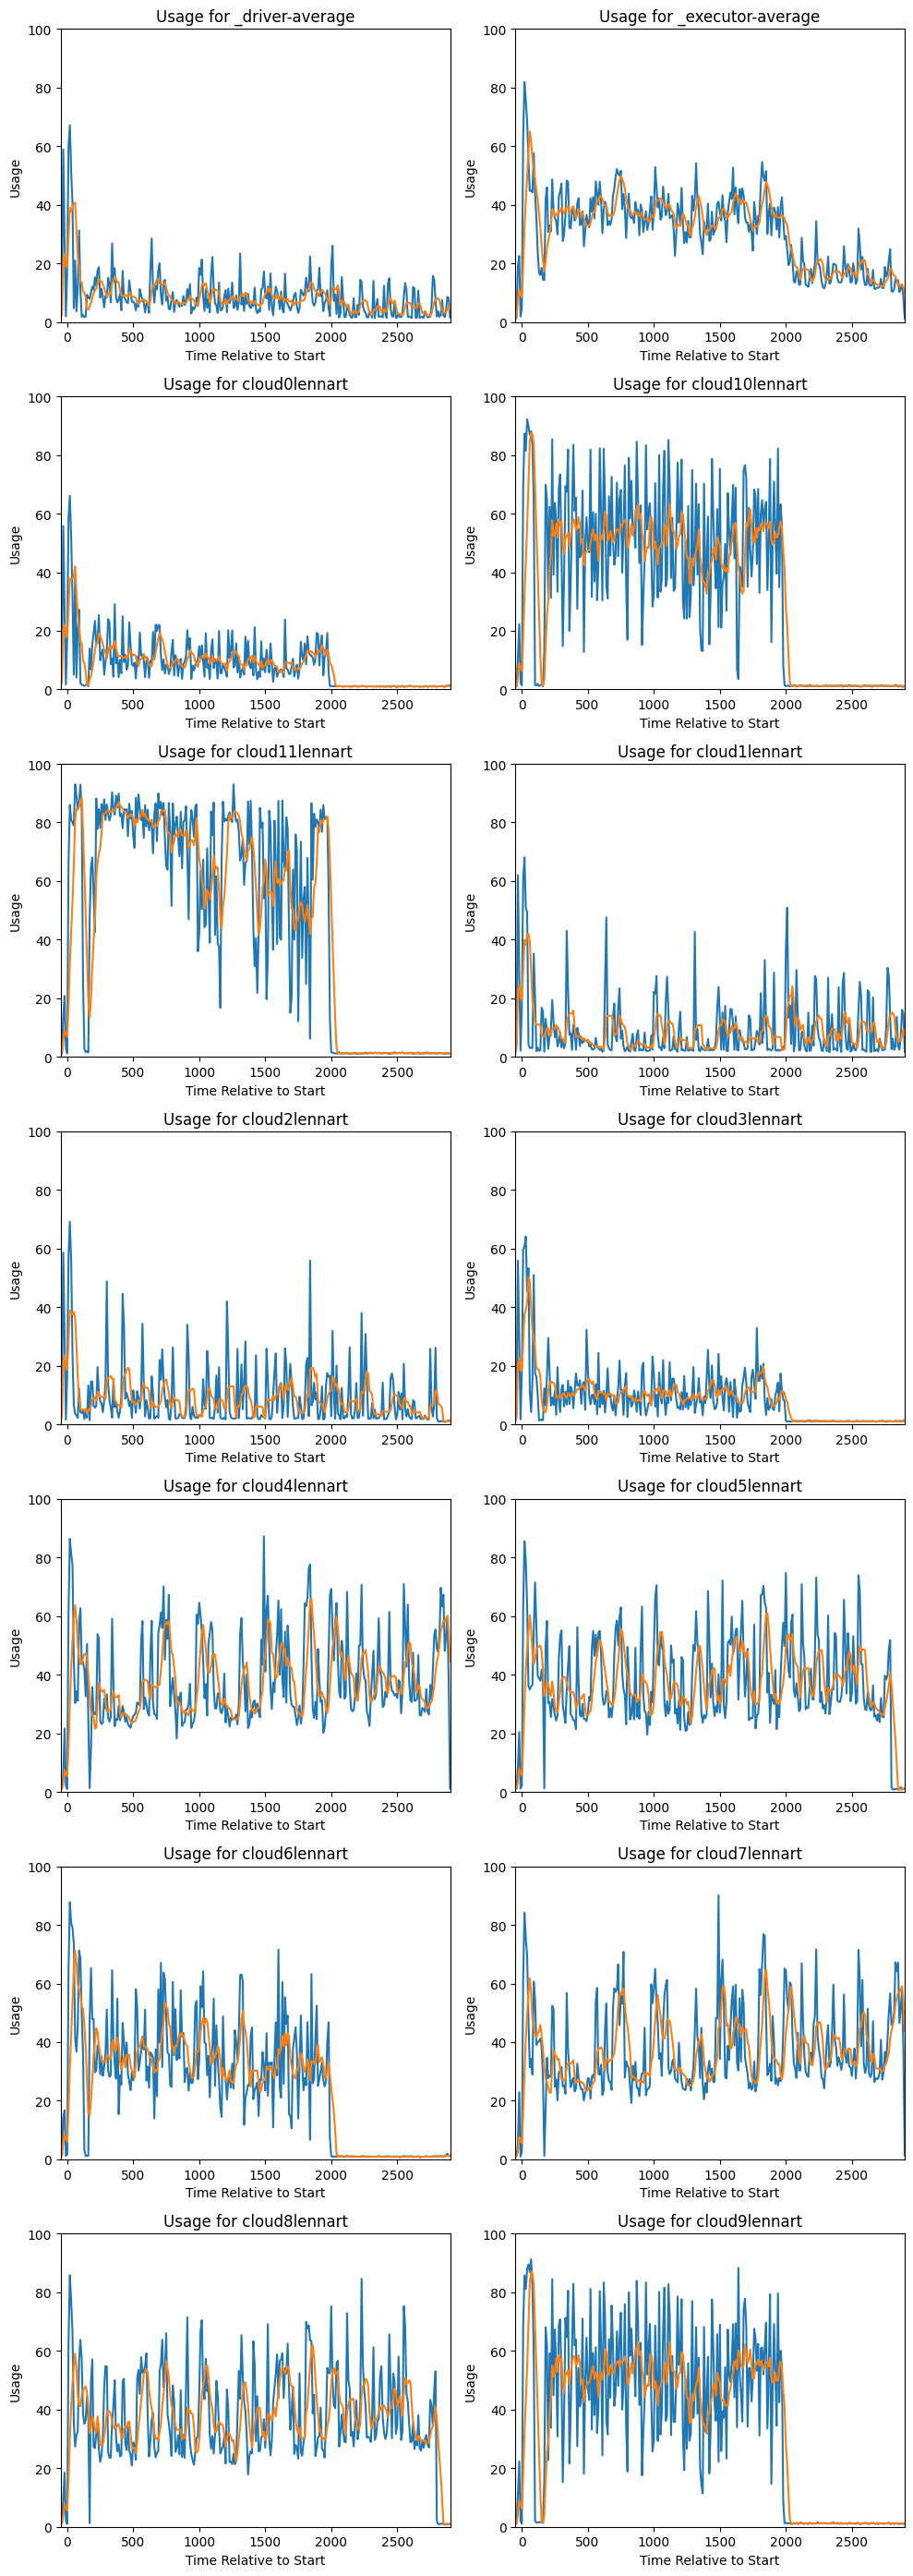

field,time,host,available,buffered,free,shared,total,used,time_rel,available_rel,buffered_rel,free_rel,shared_rel,total_rel,used_rel
0,2024-06-15 02:28:30,cloud0lennart,32859127808,71471104,29966712832,1400832,33660653568,334893056,-48.0,0.976188,0.002123,0.890259,0.000042,1.0,0.009949
1,2024-06-15 02:28:30,cloud10lennart,32869629952,69074944,29896953856,1400832,33660653568,328466432,-48.0,0.976500,0.002052,0.888187,0.000042,1.0,0.009758
2,2024-06-15 02:28:30,cloud11lennart,32861495296,71929856,29890338816,1400832,33660649472,331341824,-48.0,0.976259,0.002137,0.887991,0.000042,1.0,0.009844
3,2024-06-15 02:28:30,cloud1lennart,32773591040,44503040,29585989632,1417216,33660665856,399626240,-48.0,0.973647,0.001322,0.878948,0.000042,1.0,0.011872
4,2024-06-15 02:28:30,cloud2lennart,32832577536,44367872,29615382528,1413120,33660653568,340811776,-48.0,0.975399,0.001318,0.879822,0.000042,1.0,0.010125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2024-06-15 03:17:40,cloud5lennart,32828755968,57442304,29570830336,1413120,33660653568,344633344,2902.0,0.975286,0.001707,0.878498,0.000042,1.0,0.010238
3548,2024-06-15 03:17:40,cloud6lennart,32854745088,73957376,29854826496,1400832,33660653568,337027072,2902.0,0.976058,0.002197,0.886935,0.000042,1.0,0.010012
3549,2024-06-15 03:17:40,cloud7lennart,32857804800,76398592,29881593856,1400832,33660665856,334368768,2902.0,0.976148,0.002270,0.887730,0.000042,1.0,0.009934
3550,2024-06-15 03:17:40,cloud8lennart,32793669632,75620352,29804085248,1404928,33660653568,397918208,2902.0,0.974243,0.002247,0.885428,0.000042,1.0,0.011821


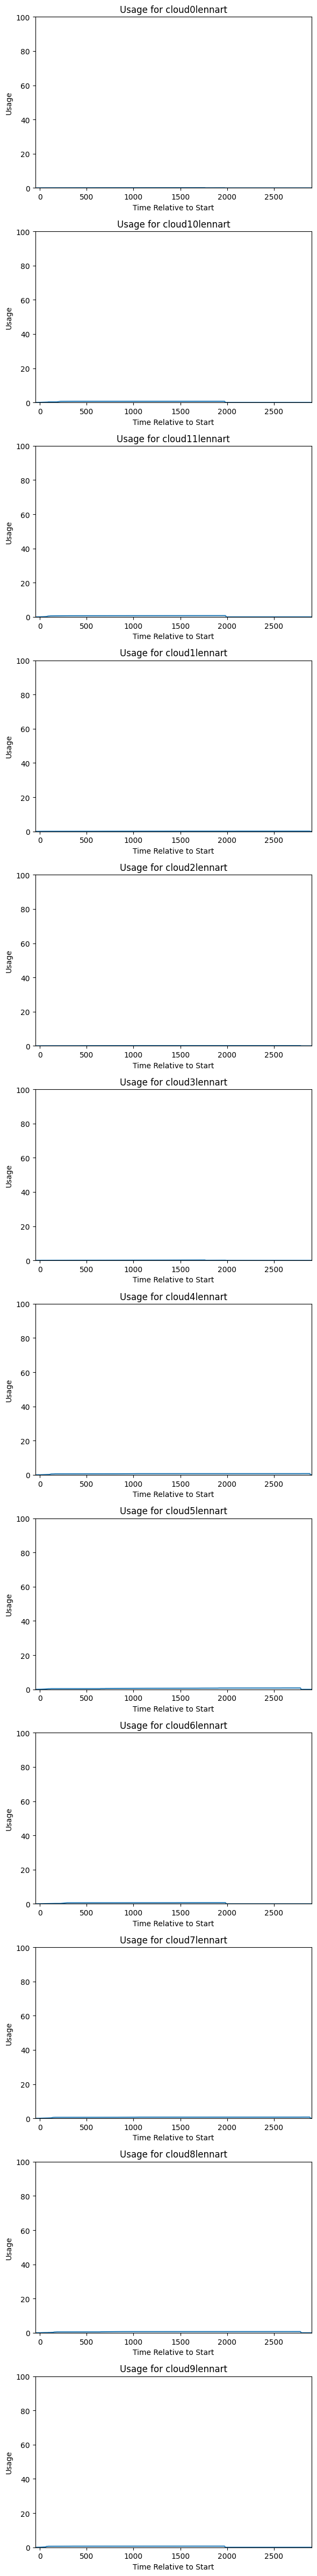

In [6]:

workload, time = 'constant-i4qd60sf550d1800_4','1718418558'
plot_cpu(workload, time, 2)
plot_mem(workload, time, 2)


# plot_mem(workload, start)